In [1]:
from collections import defaultdict
import warnings
from tkinter.constants import FIRST

from lightning.pytorch.callbacks import ModelCheckpoint
import stock_indicators as sa
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import yfinance as yf
from stock_indicators import PeriodSize, Quote
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.6f}'.format)
from tqdm.autonotebook import tqdm
from cvxopt import matrix, solvers

C:\Users\nyamelka\miniconda3\envs\HF_Thesis\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080 SUPER'

In [3]:
funds_w_names = defaultdict(pd.DataFrame)

In [4]:
etf_names = ['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS','IE00B0M62X26','IE00B14X4Q57','IE00B1XNHC34','IE00B3FH7618','IE00B3ZW0K18','IE00B52MJY50','IE00B5M4WH52','IE00B66F4759','EMBE.L', 'DTLE.L','IE00BDFK1573','IBC5.DE','IE00BFNM3G45','IE00BHZPJ015','IE00BHZPJ452','IE00BHZPJ783',
'IE00BLDGH553','IE00BMG6Z448','IE00BYYHSM20','IE00BYZTVT56','IE00BZ173V67','IE00BZ1NCS44','ISVIF', "IESE.AS", "UEEF.DE"]

In [5]:
print(etf_names)

['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS', 'IE00B0M62X26', 'IE00B14X4Q57', 'IE00B1XNHC34', 'IE00B3FH7618', 'IE00B3ZW0K18', 'IE00B52MJY50', 'IE00B5M4WH52', 'IE00B66F4759', 'EMBE.L', 'DTLE.L', 'IE00BDFK1573', 'IBC5.DE', 'IE00BFNM3G45', 'IE00BHZPJ015', 'IE00BHZPJ452', 'IE00BHZPJ783', 'IE00BLDGH553', 'IE00BMG6Z448', 'IE00BYYHSM20', 'IE00BYZTVT56', 'IE00BZ173V67', 'IE00BZ1NCS44', 'ISVIF', 'IESE.AS', 'UEEF.DE']


In [6]:
for fund in etf_names:
    print(fund)
    a = (pd.DataFrame(yf.Ticker(fund).history(start="2023-01-03", end="2024-01-01")))
    a.index = pd.to_datetime(a.index)
    a.index = a.index.normalize()
    full_date_range = pd.date_range(start=a.index.min(), end=a.index.max(), freq="D")
    a = a.reindex(full_date_range)

    a["Return"] = a["Close"].pct_change()
    a["Rolling Volatility"] = a["Return"].rolling(7).std()
    
    a.fillna(method="bfill", inplace=True)
    if fund != 'ISVIF':
        a.drop(["Dividends", "Stock Splits", "Capital Gains"], inplace=True, axis=1)
    else:
        a.drop(["Dividends", "Stock Splits"], inplace=True, axis=1)
    funds_w_names[fund] = a

IE0005042456
EDMU.SW
EDG2.L
36BA.DE
CBUS.DE
EWSA.AS
IE00B0M62X26
IE00B14X4Q57
IE00B1XNHC34
IE00B3FH7618
IE00B3ZW0K18
IE00B52MJY50
IE00B5M4WH52
IE00B66F4759
EMBE.L
DTLE.L
IE00BDFK1573
IBC5.DE
IE00BFNM3G45
IE00BHZPJ015
IE00BHZPJ452
IE00BHZPJ783
IE00BLDGH553
IE00BMG6Z448
IE00BYYHSM20
IE00BYZTVT56
IE00BZ173V67
IE00BZ1NCS44
ISVIF
IESE.AS
UEEF.DE


In [7]:
funds_w_names["IE00B3ZW0K18"]

,Open,High,Low,Close,Volume,Return,Rolling Volatility
2023-01-03 00:00:00+00:00,82.620003,83.059998,81.500000,81.595001,47122.000000,0.012930,0.013768
2023-01-04 00:00:00+00:00,82.099998,82.699997,81.809998,82.650002,49951.000000,0.012930,0.013768
2023-01-05 00:00:00+00:00,82.209999,82.610001,81.330002,81.425003,11901.000000,-0.014822,0.013768
2023-01-06 00:00:00+00:00,81.559998,82.839996,81.379997,82.720001,12311.000000,0.015904,0.013768
2023-01-07 00:00:00+00:00,83.370003,84.480003,83.349998,84.360001,23945.000000,0.000000,0.013768
...,...,...,...,...,...,...,...
2023-12-25 00:00:00+00:00,100.370003,100.769997,100.349998,100.639999,75297.000000,0.000000,0.004045
2023-12-26 00:00:00+00:00,100.370003,100.769997,100.349998,100.639999,75297.000000,0.000000,0.003640
2023-12-27 00:00:00+00:00,100.370003,100.769997,100.349998,100.639999,75297.000000,0.005595,0.004243
2023-12-28 00:00:00+00:00,100.959999,101.000000,100.779999,100.879997,14227.000000,0.002385,0.002214


In [41]:
# import pickle
# pickle.dump(funds_w_names, open('funds_w_names.pkl', 'wb'))

In [42]:
# import pickle
# pickle.dump(funds_w_names, open('funds_w_names_2.pkl', 'wb'))

In [43]:
funds_w_names['EWSA.AS']

,Open,High,Low,Close,Volume,Return,Rolling Volatility
2023-01-03 00:00:00+01:00,4.201800,4.215000,4.201800,4.207100,66.000000,0.004088,0.010457
2023-01-04 00:00:00+01:00,4.195300,4.224300,4.195300,4.224300,1900.000000,0.004088,0.010457
2023-01-05 00:00:00+01:00,4.221000,4.221000,4.221000,4.221000,0.000000,-0.000781,0.010457
2023-01-06 00:00:00+01:00,4.190500,4.190500,4.190500,4.190500,0.000000,-0.007226,0.010457
2023-01-07 00:00:00+01:00,4.298600,4.298600,4.298600,4.298600,0.000000,0.000000,0.010457
...,...,...,...,...,...,...,...
2023-12-25 00:00:00+01:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.000000,0.007116
2023-12-26 00:00:00+01:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.000000,0.005419
2023-12-27 00:00:00+01:00,4.810600,4.810600,4.810600,4.816900,0.000000,0.009261,0.005989
2023-12-28 00:00:00+01:00,4.844000,4.844000,4.807200,4.807200,5484.000000,-0.002014,0.004963


In [7]:
def portfolio_factory(etfs: list):
    giga_fund = pd.DataFrame()
    for c, ff in enumerate(etfs):
        f = ff.copy()
        # Ensure index is datetime
        f.index = pd.to_datetime(f.index, utc=True)

        # f.index = f.index.normalize()
        f.index = f.index.map(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

        # Sort by datetime index (important for time series models)
        f = f.sort_index()

        # Add time_idx relative to the start of the individual ETF
        f["time_idx"] = (f.index - f.index.min()).days

        # Add unique group_id
        f["group_id"] = c

        # Reset index to avoid issues with overlapping indices
        f = f.reset_index(drop=True)

        # Concatenate into the master DataFrame
        giga_fund = pd.concat([giga_fund, f], ignore_index=False)
    return giga_fund

In [8]:
pd.options.display.date_yearfirst = True  # Ensures year-first format
pd.options.display.float_format = '{:.2f}'.format  # Example for float formatting

In [8]:
from stock_indicators.indicators.common.enums import PeriodSize
def technical_indicators_factory(etfs: list, names: list):
    indicators_per_fund = defaultdict(pd.DataFrame)
    figs = []

    for id, f in enumerate(etfs):
        quotes_for_f = [
            Quote(
                date=row.Index,
                open=row.Open,
                high=row.High,
                low=row.Low,
                close=row.Close,
                volume=row.Volume
            )
            for row in f.itertuples()]


        macd_for_f = sa.indicators.get_macd(quotes=quotes_for_f)
        valid_macd_for_f = [
            (result.date, result.macd, result.signal, result.histogram)
            for result in macd_for_f
            if result.macd is not None and result.signal is not None and result.histogram is not None
        ]
        macd_dates, macd_values, macd_signal, macd_histogram = zip(*valid_macd_for_f)


        rsi_for_f = sa.indicators.get_rsi(quotes=quotes_for_f)
        valid_rsi_for_f = [
            (result.date, result.rsi)
            for result in rsi_for_f
            if result.date is not None and result.rsi is not None
        ]
        rsi_dates, rsi_values = zip(*valid_rsi_for_f)


        bb_for_f = sa.indicators.get_bollinger_bands(quotes=quotes_for_f)
        valid_bb_for_f = [
            (result.date, result.lower_band, result.upper_band)
            for result in bb_for_f
            if result.date is not None and result.lower_band is not None
        ]
        bb_dates, bb_lower, bb_upper = zip(*valid_bb_for_f)


        vwap_for_f = sa.indicators.get_vwap(quotes=quotes_for_f)
        valid_vwap_for_f = [
            (result.date, result.vwap)
            for result in vwap_for_f
            if result.date is not None and result.vwap is not None
        ]
        vwap_dates, vwap_values = zip(*valid_vwap_for_f)



        pp_for_f = sa.indicators.get_pivot_points(quotes=quotes_for_f, window_size=PeriodSize.DAY)
        valid_pp_for_f = [
            (result.date, result.pp, result.r1, result.r2, result.r3, result.r4, result.s1, result.s2, result.s3, result.s4)
            for result in pp_for_f
            if result.date is not None and result.pp is not None
        ]
        pp_dates, pp, r1, r2, r3, r4, s1, s2, s3, s4 = zip(*valid_pp_for_f)



    
        fig, axes = plt.subplots(5, 1, figsize=(12,6))


        axes[0].plot(macd_dates[-20:], macd_values[-20:], label='MACD_values', linewidth=2)
        axes[0].plot(macd_dates[-20:], macd_signal[-20:], label='MACD_signal', linewidth=2)
        axes[0].legend(loc='best')
        
        axes[1].plot(rsi_dates[-20:], rsi_values[-20:], label='RSI', linewidth=2)
        axes[1].legend(loc='best')

        axes[2].plot(bb_dates[-20:], bb_lower[-20:], label='BB_lower', linewidth=2)
        axes[2].plot(bb_dates[-20:], bb_upper[-20:], label='BB_upper', linewidth=2)
        axes[2].legend(loc='best')

        axes[3].plot(vwap_dates[-20:], vwap_values[-20:], label='vwap', linewidth=2)
        axes[3].legend(loc='best')

        axes[4].plot(pp_dates[-20:], pp[-20:], label='pivot points', linewidth=2)
        axes[4].plot(pp_dates[-20:], r1[-20:], label='r1', linewidth=2)
        axes[4].plot(pp_dates[-20:], r4[-20:], label='r4', linewidth=2)
        axes[4].plot(pp_dates[-20:], s1[-20:], label='s1', linewidth=2)
        axes[4].plot(pp_dates[-20:], s4[-20:], label='s4', linewidth=2)
        axes[4].legend(loc='best')

    
        figs.append(fig)

        f['Bullish'] = [1 if x.histogram and x.histogram > 0 else 0 for x in macd_for_f]
        f['Bearish'] = [1 if x.histogram and x.histogram < 0 else 0 for x in macd_for_f]
        f['isOverbought'] = [1 if x.rsi and x.rsi > 70 else 0 for x in rsi_for_f ]
        f['isOversold'] = [1 if x.rsi and x.rsi < 30 else 0 for x in rsi_for_f ]


        f.fillna(method="ffill", inplace=True)
        indicators_per_fund[names[id]]= f
    return indicators_per_fund, figs

In [9]:
def fit_predict(pred_len, epochs: int, batch_size: int, lr: float, dropout: float, df: pd.DataFrame, independent_variables: list, target="Close", training_cutoff_idx: pd.Timestamp=333):
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff_idx],  # Use the determined cutoff index
        time_idx="time_idx",                              # Sequential time index
        target=target,                                    # Target variable
        group_ids=["group_id"],                           # Group identifier
        min_encoder_length=22,                             # Minimum input sequence length
        max_encoder_length=365,                            # Maximum input sequence length
        min_prediction_length=1,                         # Minimum forecast length
        max_prediction_length=pred_len,                   # Maximum forecast length (31 for December)
        static_reals=[],                                  # No static real variables
        time_varying_known_reals= independent_variables,  # Known inputs
        time_varying_unknown_reals=[target],              # Target variable
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
        add_relative_time_idx=True,                       # Add relative time index
        add_target_scales=True,                           # Scale the target variable
        add_encoder_length=True,                          # Include encoder length feature
        allow_missing_timesteps=False,                    # Ensure no missing steps
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=True,
        stop_randomization=True                             # Ensures no randomization in validation dataset
    )

    batch_size = batch_size

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=lr,              # Learning rate
        hidden_size=16,                  # Model hidden size
        attention_head_size=1,           # Number of attention heads
        dropout=dropout,                     # Dropout rate
        hidden_continuous_size=8,        # Hidden size for continuous variables
        output_size=7,                   # Output quantiles (e.g., 10th to 90th percentile)
        loss=QuantileLoss(),             # Loss function
        log_interval=10,                 # Log every 10 batches
        reduce_on_plateau_patience=4,    # Reduce learning rate on plateau
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints/",
        filename="tft-model-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        monitor="val_loss",  # 
        mode="min",  # minimize validation loss
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=8, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        # logger=logger,
        max_epochs=epochs,
        accelerator='cuda',
        devices="auto",
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback, lr_logger],#, checkpoint_callback],
    )

    trainer.fit(tft, train_dataloader, val_dataloader)
    raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)
    predicted_median_np = raw_predictions.output.prediction[0, :, 1].detach().cpu().numpy()
    return predicted_median_np

In [10]:
def metrics_and_plt(df: pd.DataFrame, preds:list, date_range:pd.date_range, target="Close", date = "2023-12-01"):
    actual_values = df[target][date:]
    mse = mean_squared_error(actual_values, preds)

    plt.figure(figsize=(10, 6))
    plt.plot(date_range, actual_values, marker="x", label="Actual Close", color="orange")
    plt.plot(date_range, preds, marker="o", label="Predicted Median")
    plt.title("Predicted Values for December 01 to December 29, 2023")
    plt.xlabel("Date")
    plt.ylabel("Predicted Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    return mse, plt

NO INDICATORS, ONE ETF

In [12]:
#IE00B52MJY50
IE = portfolio_factory(etfs=[funds_w_names['EWSA.AS']])

In [60]:
IE

,index,Open,High,Low,Close,Volume,Return,Rolling Volatility,time_idx,group_id
0,2023-01-02 00:00:00+00:00,4.20,4.22,4.20,4.21,66.00,0.00,0.01,0,0
1,2023-01-03 00:00:00+00:00,4.20,4.22,4.20,4.22,1900.00,0.00,0.01,1,0
2,2023-01-04 00:00:00+00:00,4.22,4.22,4.22,4.22,0.00,-0.00,0.01,2,0
3,2023-01-05 00:00:00+00:00,4.19,4.19,4.19,4.19,0.00,-0.01,0.01,3,0
4,2023-01-06 00:00:00+00:00,4.30,4.30,4.30,4.30,0.00,0.00,0.01,4,0
...,...,...,...,...,...,...,...,...,...,...
356,2023-12-24 00:00:00+00:00,4.81,4.81,4.81,4.82,0.00,0.00,0.01,356,0
357,2023-12-25 00:00:00+00:00,4.81,4.81,4.81,4.82,0.00,0.00,0.01,357,0
358,2023-12-26 00:00:00+00:00,4.81,4.81,4.81,4.82,0.00,0.01,0.01,358,0
359,2023-12-27 00:00:00+00:00,4.84,4.84,4.81,4.81,5484.00,-0.00,0.00,359,0


In [61]:
print(IE['index'].dtype)

datetime64[ns, UTC]


In [63]:
IE_preds = fit_predict(pred_len=29, epochs=100, batch_size=128, lr=1e-3, dropout=0.1, df=IE, independent_variables=["Open", "High", "Low", "Volume"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 144    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.0 K  | train
7  | static_cont

Epoch 0:  50%|█████     | 2/4 [00:00<00:00,  6.28it/s, v_num=22, train_loss_step=0.160]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
IE_mse, IE_plt = metrics_and_plt(IE, IE_preds, pd.date_range(start="2023-12-01", end="2023-12-29"))

In [ ]:
IE_mse

ADDING INDICATORS

In [ ]:
IE_indicators, IE_indicators_plt1 = technical_indicators_factory([funds_w_names['EWSA.AS']], ['EWSA.AS'])

In [ ]:
analiza = IE_indicators["EWSA.AS"][["isOversold", "isOverbought", "Bullish", "Bearish", "Return"]]

In [ ]:
import seaborn as sns
corr1 = analiza.corr()
sns.heatmap(corr1, annot=True, cmap="coolwarm", fmt=".2f")

In [ ]:
correlations = IE_indicators["EWSA.AS"].corr()

In [ ]:
import seaborn as sns

sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")

In [ ]:
IE_indicators_preds = fit_predict(pred_len=29, epochs=220, batch_size=128, lr=1e-3, dropout=0.1, df=IE_indicators["EWSA.AS"], independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"])

In [ ]:
IE_indicators_mse, IE_indicators_plt2= metrics_and_plt(IE, IE_indicators_preds, pd.date_range(start="2023-12-01", end="2023-12-29"))

In [ ]:
IE_indicators_mse

ENSAMBLE MODEL 2: REMAINDERS

In [ ]:
resztki = abs(IE_indicators_preds  - IE_indicators["EWSA.AS"]["Close"]["2023-12-01":])

In [ ]:
resztki

In [ ]:
df_scary = IE_indicators["EWSA.AS"][333:].copy()
df_scary["Remainders"] = resztki

In [ ]:
df_scary

In [ ]:
df_scary.index = pd.to_datetime(df_scary.index)  # ensure index is datetime if not already
df_scary["time_idx"] = (df_scary.index.date - df_scary.index.date[0]).astype("timedelta64[D]").astype(int)
df_scary['group_id'] = 0

In [ ]:
IE_model2 = fit_predict(pred_len=7,epochs=220, batch_size=128, lr=1e-3, dropout=0.1, df=df_scary, independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"], target="Remainders")

In [ ]:
IE_model2_mse, IE_model2_plt= metrics_and_plt(df_scary, IE_model2, pd.date_range(start="2023-12-23", end="2023-12-29"), target="Remainders", date="2023-12-23")

In [ ]:
final_preds = IE_indicators_preds.copy()[-7:] + IE_model2

In [ ]:
final_mse = mean_squared_error(IE_indicators["EWSA.AS"]["Close"][-7:], final_preds)

In [ ]:
final_mse

FULL HEDGE PORTFOLIO

In [11]:
funds_for_hedge = ["ISVIF", "IE00BHZPJ783", "36BA.DE", "IE00B3ZW0K18", "IE00BMG6Z448"]

In [12]:
funds_with_indics = []
for fund in funds_for_hedge:
    funds_with_indics.append(funds_w_names[fund].copy())

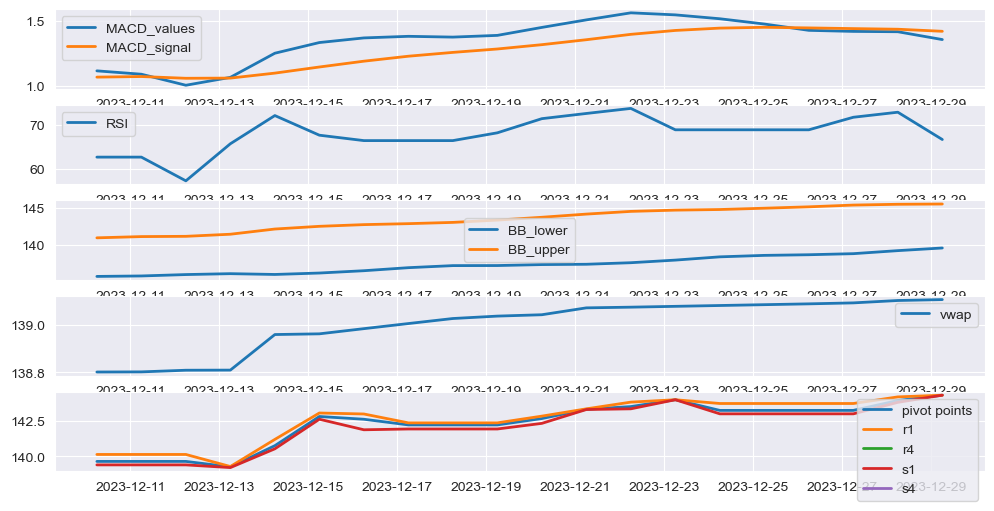

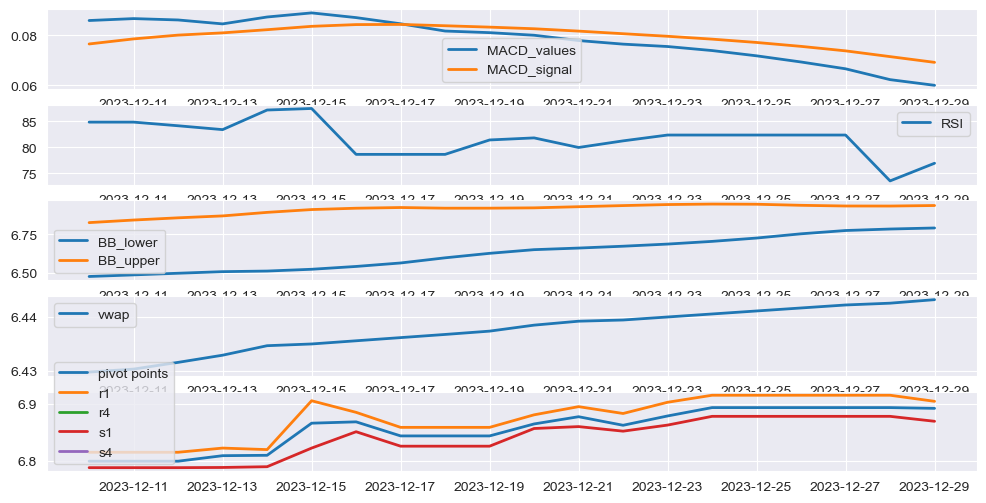

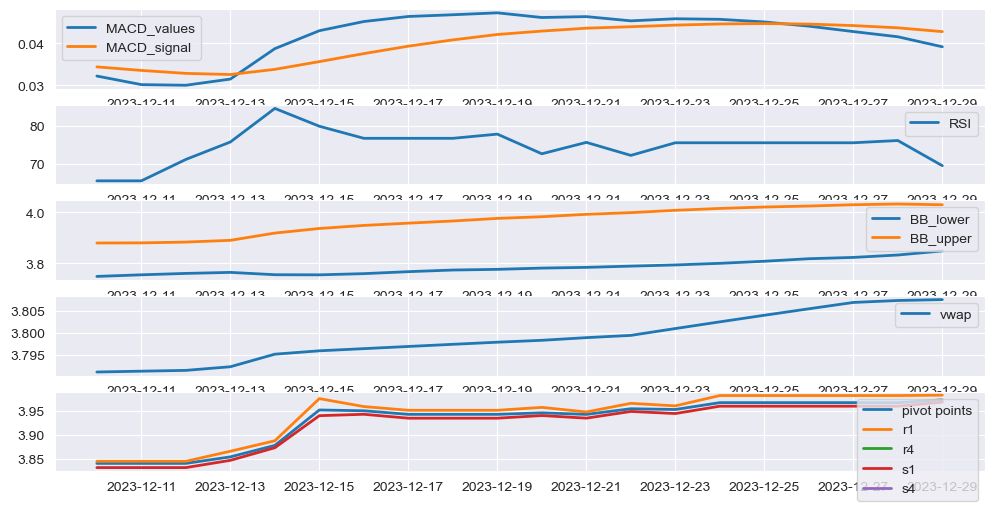

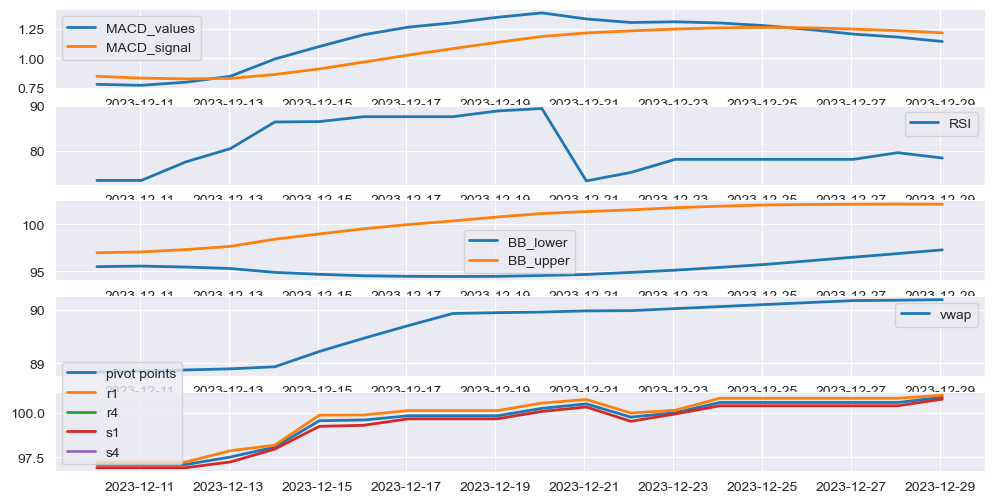

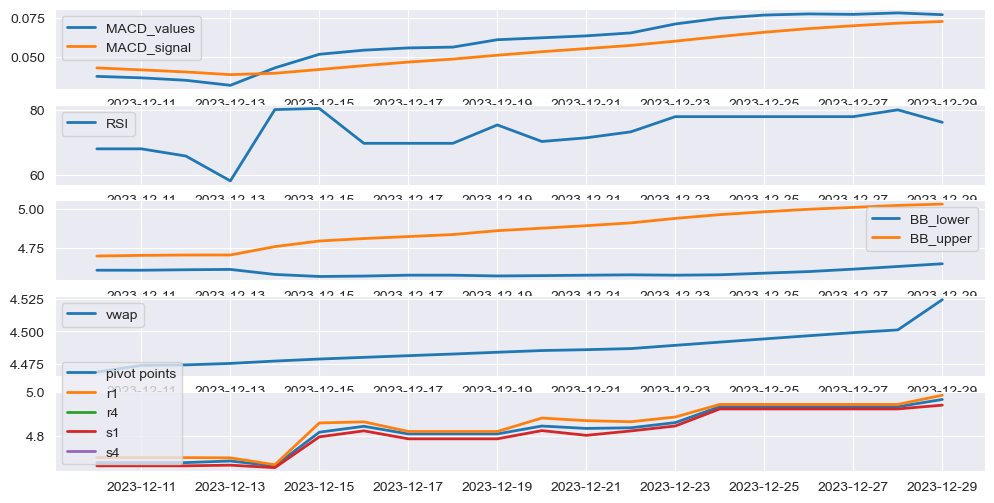

In [13]:
fund_name_fund_df, sum_plt = technical_indicators_factory(funds_with_indics, funds_for_hedge)

In [14]:
GIGAFUND = portfolio_factory(etfs=[funds_w_names[k] for k in (funds_for_hedge)])

In [15]:
GIGAFUND_NORM = GIGAFUND.copy()

columns_to_normalize = ["Open", "High", "Low", "Close", "Volume", "Return", "Rolling Volatility"]

GIGAFUND_NORM[columns_to_normalize] = (
    GIGAFUND_NORM[columns_to_normalize]
    .apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0)
)

In [16]:
GIGAFUND_NORM

,Open,High,Low,Close,Volume,Return,Rolling Volatility,time_idx,group_id
0,0.949093,0.951707,0.949099,0.951708,0.001870,0.404490,0.326833,0,0
1,0.951712,0.951707,0.951717,0.951708,0.000000,0.404490,0.326833,1,0
2,0.951468,0.951463,0.948750,0.950556,0.004450,0.386149,0.326833,2,0
3,0.965587,0.965584,0.964767,0.964761,0.000387,0.630869,0.326833,3,0
4,0.966488,0.966485,0.965221,0.965215,0.001032,0.404490,0.326833,4,0
...,...,...,...,...,...,...,...,...,...
356,0.009465,0.009366,0.009425,0.009323,0.053730,0.404490,0.328282,356,4
357,0.009465,0.009366,0.009425,0.009323,0.053730,0.404490,0.161586,357,4
358,0.009465,0.009366,0.009425,0.009323,0.053730,0.606297,0.281416,358,4
359,0.009658,0.009711,0.009598,0.009505,0.043859,0.486764,0.286456,359,4


In [17]:
duplicate_rows = GIGAFUND_NORM[GIGAFUND_NORM.duplicated(subset=["time_idx", "group_id"], keep=False)]
print(duplicate_rows)

       Open     High      Low    Close   Volume   Return  Rolling Volatility  \
68 0.959784 0.959780 0.959789 0.959781 0.000193 0.404490            0.441330   
69 0.959784 0.959780 0.959789 0.959781 0.000193 0.404490            0.448232   
82 0.018694 0.018596 0.018448 0.018431 0.017906 0.404490            0.494184   
83 0.018694 0.018596 0.018448 0.018431 0.017906 0.563158            0.506034   
82 0.001863 0.001838 0.001817 0.001642 0.075987 0.404490            0.133048   
83 0.001863 0.001838 0.001817 0.001642 0.075987 0.295830            0.229393   
82 0.569562 0.570776 0.565767 0.567853 0.017805 0.404490            0.434932   
83 0.569562 0.570776 0.565767 0.567853 0.017805 0.578558            0.495957   
82 0.004418 0.004335 0.004523 0.004359 0.000956 0.404490            0.491969   
83 0.004418 0.004335 0.004523 0.004359 0.000956 0.425882            0.461198   

    time_idx  group_id  
68        68         0  
69        68         0  
82        82         1  
83        82       

In [18]:
IE_indicators_preds = fit_predict(pred_len=29, epochs=220, batch_size=128, lr=1e-3, dropout=0.1, df=GIGAFUND_NORM, independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"])

AssertionError: data index has to be unique

RISK: Monte Carlo and Transformer Predicting VARIANCE

In [ ]:
def calc_drift(funds):
    drift_dict={}
    for k, v in funds.items():
        log_returns = np.log(1+funds[k]["Close"].pct_change())
        log_returns.fillna(value=0, inplace=True)
        avg_pdr = log_returns.mean()
        var = log_returns.var()
        drift = avg_pdr-(.5*var)
        drift_dict[k]=drift
    return drift_dict

In [ ]:
def monte_carlo_sim(funds, drifts):
    price_paths={}
    for k, v in funds.items():
        log_returns = np.log(1+funds[k]["Close"].pct_change())
        log_returns.fillna(value=0, inplace=True)
        stdev=log_returns.std()
        days=362
        trials=100
        Z = norm.ppf(np.random.rand(days,trials))
        daily_returns=np.exp(np.array(drifts[k]) + np.array(stdev) * Z)
        price_paths[k] = np.zeros_like(daily_returns)
        price_paths[k][0] = funds[k]["Close"].iloc[-1]
        for i in range(1,days):
            price_paths[k][i] = price_paths[k][i-1] * daily_returns[i-1]
    return price_paths

In [ ]:
drifts=calc_drift(funds_w_names)
pp=monte_carlo_sim(funds_w_names, drifts=drifts)

In [ ]:
pp['EWSA.AS']

In [ ]:
pps= pd.DataFrame(pp['EWSA.AS'])
pps = pps.pct_change()
pps.fillna(value=0, inplace=True)
pps= pps.rolling(7).std()
pps.fillna(method="bfill", inplace=True)
pps

In [ ]:
EWSA_volatility = pd.DataFrame(pps)
EWSA_volatility= EWSA_volatility.mean(axis=1)

In [ ]:
EWSA_volatility

In [ ]:
pps

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(pp["EWSA.AS"])

CHOLESKY MONTE CARLO

In [ ]:
def nearest_positive_definite(matrix):
    P = matrix.copy()
    eigvals, eigvecs = np.linalg.eigh(P)
    eigvals[eigvals < 0] = 1e-10 
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

In [ ]:
variances = {}
covs_means = []
for k,v in funds_w_names.items():
    variances[k] = v["Rolling Volatility"]
variances = pd.DataFrame(variances)
r = variances.pct_change()
covariance_matrix = r.cov()
mean_returns = r.mean()

In [ ]:
if not np.all(np.linalg.eigvals(covariance_matrix) > 0): 
    print("Covariance matrix not positive definite. Adding regularization.")
    covariance_matrix = nearest_positive_definite(covariance_matrix)

In [ ]:
covariance_matrix

In [ ]:
#to be filled with real data
portfolio_weights = np.random.random(len(mean_returns)) # distribution of etfs in portfolio
portfolio_weights /= np.sum(portfolio_weights)

In [ ]:
initial_portfoloio = 0
for i, v in enumerate(funds_w_names.values()):
    initial_portfoloio += portfolio_weights[i] * v["Close"][i]

In [ ]:
days = 60
simulations = 100
portfolio_sims = np.full(shape=(days, simulations), fill_value=0.0) # default
mean_matrix = np.full(shape=(days, len(portfolio_weights)), fill_value=mean_returns).T # days x all etfs

In [ ]:
initial_portfoloio

In [ ]:
for s in range(0, simulations):
    Z = np.random.normal(size=(days, len(portfolio_weights)))
    L = np.linalg.cholesky(covariance_matrix)
    daily_returns = mean_matrix + np.inner(L, Z)
    portfolio_sims[:, s] = np.cumprod(np.inner(portfolio_weights, daily_returns.T)+1)*initial_portfoloio
        
plt.plot(portfolio_sims)
plt.ylabel("Portfolio Simulations")

In [ ]:
discounted_prices = [sim[-1]*0.96 for sim in portfolio_sims]

In [ ]:
avg = np.average(discounted_prices)

In [ ]:
avg

MONTE CARLO EVALUATION FUNCITON

In [ ]:
def test_robustness(paths, num_trials, tol=0.01):
    means = []
    for i in range(num_trials):
        np.random.seed(i)
        new_paths = np.random.choice(paths, size=len(paths), replace=True)
        means.append(np.mean(new_paths))
    glob_mean = np.mean(means)
    devs = np.abs(np.array(means) - glob_mean)
    return max(0, 1 - (np.mean(devs) / (tol*glob_mean)))

In [ ]:
def compute_convergence_rate(paths, true_val):
    cum_means = np.cumsum(paths)/np.arange(1, len(paths)+1)
    difs = np.abs(cum_means - true_val)
    final = difs[-1]
    avg = np.mean(difs)
    if avg == 0.0:
        return 1.0
    return max(0, 1-(final/avg))

In [ ]:
def rate_mc_simulation(paths, true_value, runtime, weights):
    mean_estimate = np.mean(paths)
    variance = np.var(paths)
    bias = mean_estimate - np.mean(true_value)
    mse = bias**2 + variance
    efficiency = 1 / (runtime * mse)

    robustness = test_robustness(paths.mean(axis=1), 150)

    convergence_rate = compute_convergence_rate(paths.mean(axis=1), true_value)

    score = (
            weights[0] * convergence_rate +
            weights[1] * (1 / np.std(paths)) +  # Inverse of variability
            weights[2] * (1 / abs(bias)) +
            weights[3] * (1 / variance) +
            weights[4] * efficiency +
            weights[5] * robustness)
    return score

In [ ]:
weights=[1/6,1/6,1/6,1/6,1/6,1/6]
pd.Series(pp['EWSA.AS'].mean(axis=1))

In [ ]:
print((rate_mc_simulation(pp['EWSA.AS'], funds_w_names["EWSA.AS"]["Close"], 0.1, weights)))